In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import csv
import os
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor 
#1. EDA STEPS 

# Veri çerçevelerini oku
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

df = pd.concat([train, test], ignore_index=True)
df = df.reset_index(drop=True)
df.head()

In [2]:
def dataframe_analys(dataframe):
    print("******SHAPE*********")
    print(dataframe.shape)       #2919,81   
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    

dataframe_analys(df)

******SHAPE*********
(2919, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object
##################### Head #####################
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...

In [3]:
#Kategorik ve numerik degiskenlerin yakalanmasi
def catch_cat_and_num_categ(dataframe, cat_threshold = 10, num_threshold = 20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] #categorik veriler
    
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_threshold and dataframe[col].dtypes != "O"]
    
    #kategorik gibi ama numerik olanlar
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > num_threshold and dataframe[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car] # boylece ham kategorikler elde ettik. cat_but_car ile ortak
                                                                   # olanları cat_cols'dan kaldirdik.
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat] # numerik gibi davranan kategorik degiskenleri numerikten
                                                                  # kaldirdik.

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = catch_cat_and_num_categ(df)

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


In [4]:
def summary_cat_num_catbutcar(dataframe,cat_cols,num_cols,cat_but_car):
    print("### CAT_COLS ###\n")
    print(dataframe[cat_cols].nunique())
    print("Dtypes\n")
    print(dataframe[cat_cols].dtypes)
    
    print("###\nNUM_COLS ###\n")
    print(dataframe[num_cols].nunique())
    print("Dtypes\n")
    print(dataframe[num_cols].dtypes)
    
    print("###\nCAT_BUT_CAR ###\n")
    print(dataframe[cat_but_car].nunique())
    print("Dtypes\n")
    print(dataframe[cat_but_car].dtypes)

summary_cat_num_catbutcar(df,cat_cols,num_cols,cat_but_car)        

### CAT_COLS ###

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
OverallCond       9
BsmtFullBath      4
BsmtHalfBath      3
FullBath          5
HalfBath          3
BedroomAbvGr      8
KitchenAbvGr      4
Fi

In [5]:
# 2-FEATURES ENGINEERING
# aykiri deger analizi
def outlier_threshold_of_cols(dataframe, variable, low_quantile=0.10, high_quantile=0.90):
    quantile_first = dataframe[variable].quantile(low_quantile) # low_quantile'a sahip deger doner
    quantile_third = dataframe[variable].quantile(high_quantile)# high_quantile'a sahip deger doner
    quantile_range = quantile_third - quantile_first
    
    up_limit = quantile_third + 1.5 * quantile_range
    low_limit = quantile_first - 1.5 * quantile_range
    
    return up_limit, low_limit

for col in num_cols:
    print(outlier_threshold_of_cols(df, col))


(6128.800000000001, -3208.8)
(270.0, -130.0)
(173.0, -35.0)
(28367.9, -9144.900000000001)
(12.5, 0.5)
(2129.0, 1801.0)
(2090.500000000001, 1865.6999999999996)
(813.75, -488.25)
(2642.2500000000014, -1585.3500000000008)
(314.0000000000009, -188.40000000000055)
(2947.500000000001, -1678.9000000000005)
(3135.0, -921.0)
(3070.3, -650.5000000000002)
(2312.5, -1387.5)
(0.0, 0.0)
(3997.3000000000006, -920.3000000000004)
(12.5, 0.5)
(2103.5, 1843.5)
(1535.0, -537.0)
(642.5, -385.5)
(328.0000000000007, -196.8000000000004)
(280.0, -168.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(20.5, -7.5)
(535287.5, -150812.5)


In [6]:
def check_of_outliers(dataframe,col_name):
    up_limit, low_limit = outlier_threshold_of_cols(dataframe,col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    if col != "SalePrice":
        print(col, check_of_outliers(df, col))

Id False
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False


In [7]:
"""
    -loc, etiket tabanli (label-based) secim yapmak icin kullanilan bir indeksleme yontemi
    -aykiri degerleri low_limit'e veya up_limit'e esitlenir
    -Aykiri degerleri baskilamak, genellikle bu degerlerin modelin performansini olumsuz yonde 
    etkilemesini onlemek veya analizdeki dengesizligi duzeltmek icin kullanilir
"""
def replace_outliers_to_thresholds(dataframe,variable):
    up_limit, low_limit = outlier_threshold_of_cols(dataframe,variable)
    dataframe.loc[(dataframe[variable] < low_limit),variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit),variable] = up_limit    
    
for col in num_cols:
    if col != "SalePrice":
        replace_outliers_to_thresholds(df,col)

In [8]:
for col in num_cols:
    if col != "SalePrice":
        print(col, check_of_outliers(df, col))

Id False
MSSubClass False
LotFrontage False
LotArea False
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
TotRmsAbvGrd False
GarageYrBlt False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
PoolArea False
MiscVal False
MoSold False


In [9]:
#category and numeric analys
"""
dataframe[col_name].value_counts(): degiskenlerde her bir benzersiz değerin kaç kez tekrarlandigini gösterir.
"Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe): her benzersiz değerin veri çerçevesindeki toplam gözlem 
                                                                    sayisina orani
"""
def cat_summary(dataframe, cat_cols, plot=True, output_file=None):
    with PdfPages(output_file) as pdf:
        for col_name in cat_cols:
            summary_df = pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)})

            # Ekrana yazdir
            print(f"{col_name} Summary:")
            print(summary_df)

            if plot:
                # Plot'u dosyaya ekleyerek oluştur
                plt.figure(figsize=(8, 6))
                sns.countplot(x=dataframe[col_name], data=dataframe)
                plt.title(f"{col_name} Count Plot")

                # Dosyaya ekleyerek kaydet
                pdf.savefig()
                plt.close()

# Dosya adini ve yolunu belirle
output_file_path = 'cat_summary_graphs.pdf'


cat_summary(df, cat_cols, plot=True, output_file=output_file_path)

MSZoning Summary:
         MSZoning      Ratio
RL           2265  77.595067
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458
Street Summary:
      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111
Alley Summary:
      Alley     Ratio
Grvl    120  4.110997
Pave     78  2.672148
LotShape Summary:
     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133
LandContour Summary:
     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498
Utilities Summary:
        Utilities      Ratio
AllPub       2916  99.897225
NoSeWa          1   0.034258
LotConfig Summary:
         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.505995
CulDSac        176   6.029462
FR2             85   2.911956
FR3             14   0.479616
LandSlope Summary:
     LandSlope   

count    2919.000000
mean     1460.000000
std       842.787043
min         1.000000
5%        146.900000
10%       292.800000
20%       584.600000
30%       876.400000
40%      1168.200000
50%      1460.000000
60%      1751.800000
70%      2043.600000
80%      2335.400000
90%      2627.200000
95%      2773.100000
99%      2889.820000
max      2919.000000
Name: Id, dtype: float64


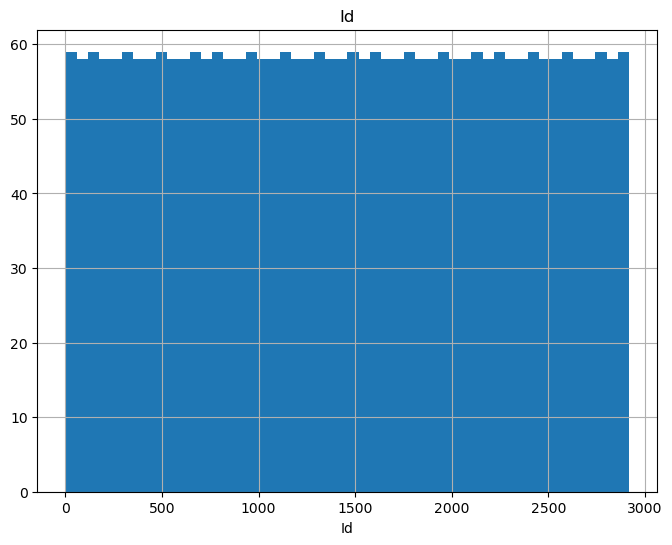

#####################################
count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
5%         20.000000
10%        20.000000
20%        20.000000
30%        20.000000
40%        30.000000
50%        50.000000
60%        60.000000
70%        60.000000
80%        80.000000
90%       120.000000
95%       160.000000
99%       190.000000
max       190.000000
Name: MSSubClass, dtype: float64


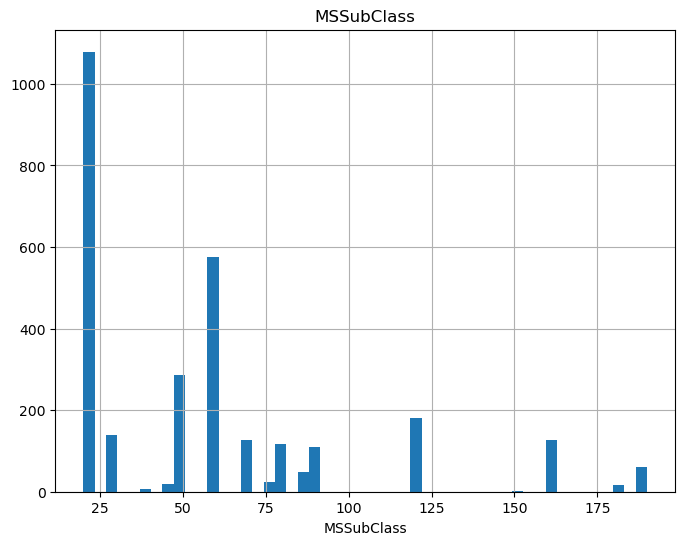

#####################################
count    2433.000000
mean       69.166050
std        22.345476
min        21.000000
5%         32.000000
10%        43.000000
20%        53.000000
30%        60.000000
40%        63.000000
50%        68.000000
60%        73.000000
70%        78.000000
80%        84.000000
90%        95.000000
95%       107.000000
99%       135.680000
max       173.000000
Name: LotFrontage, dtype: float64


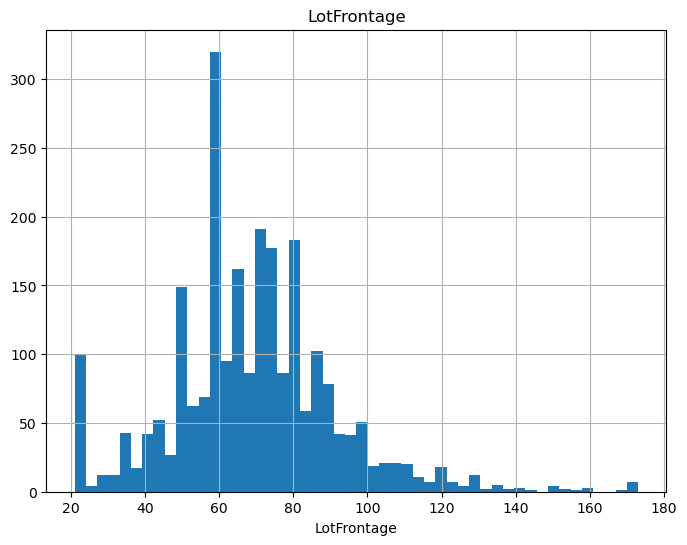

#####################################
count     2919.000000
mean      9818.098082
std       4351.591398
min       1300.000000
5%        3182.000000
10%       4922.400000
20%       7007.600000
30%       7960.400000
40%       8741.000000
50%       9453.000000
60%      10151.600000
70%      11001.200000
80%      12203.800000
90%      14300.600000
95%      17142.900000
99%      28367.900000
max      28367.900000
Name: LotArea, dtype: float64


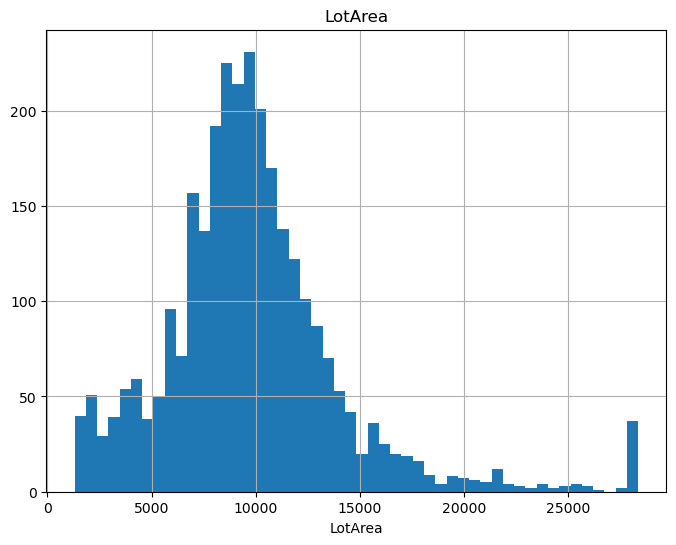

#####################################
count    2919.000000
mean        6.089072
std         1.409947
min         1.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         6.000000
70%         7.000000
80%         7.000000
90%         8.000000
95%         8.000000
99%        10.000000
max        10.000000
Name: OverallQual, dtype: float64


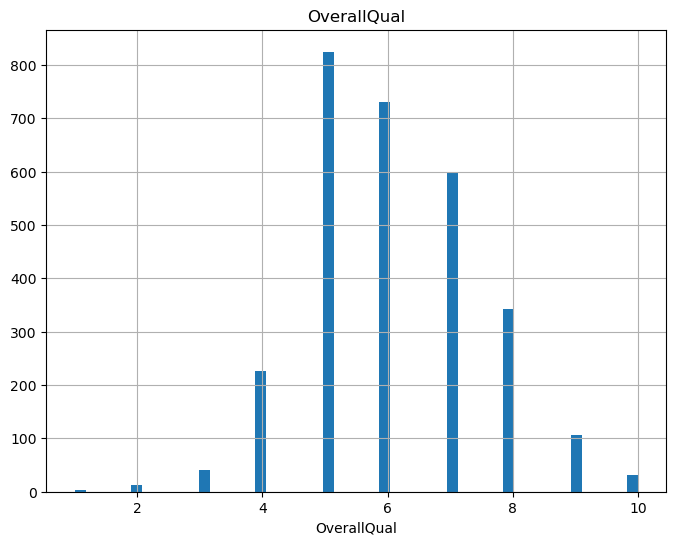

#####################################
count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
5%       1915.000000
10%      1924.000000
20%      1947.000000
30%      1957.000000
40%      1965.000000
50%      1973.000000
60%      1984.000000
70%      1998.000000
80%      2003.000000
90%      2006.000000
95%      2007.000000
99%      2008.000000
max      2010.000000
Name: YearBuilt, dtype: float64


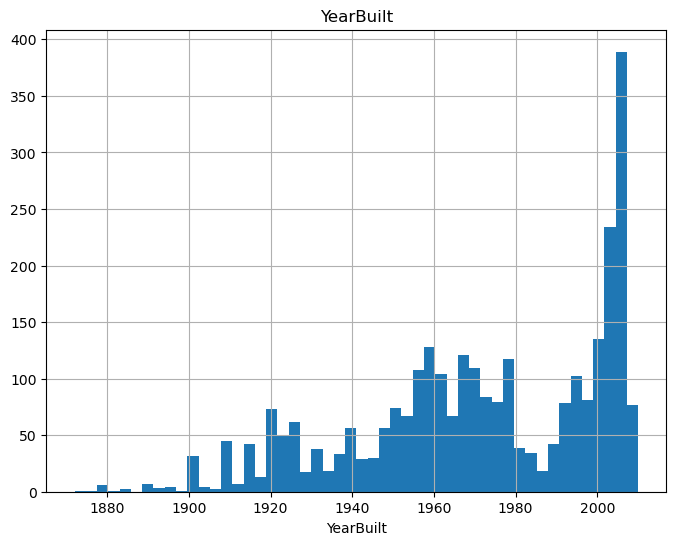

#####################################
count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
5%       1950.000000
10%      1950.000000
20%      1960.000000
30%      1970.000000
40%      1978.000000
50%      1993.000000
60%      1998.000000
70%      2002.000000
80%      2005.000000
90%      2006.200000
95%      2007.000000
99%      2009.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


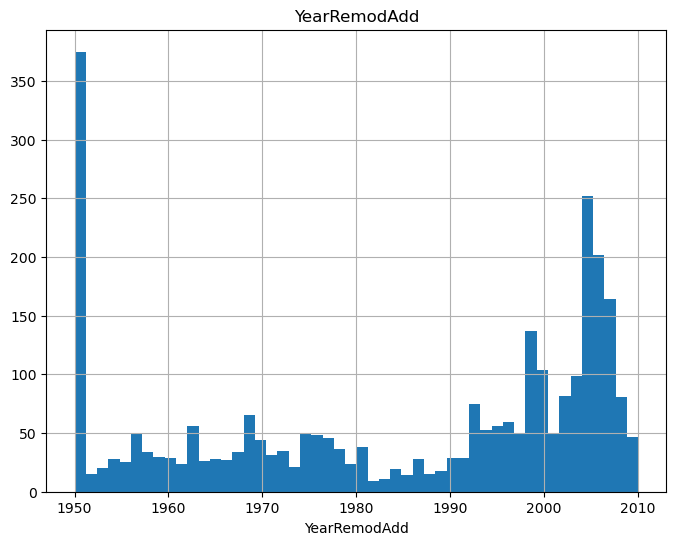

#####################################
count    2896.000000
mean      100.025035
std       168.034986
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%       120.000000
80%       202.000000
90%       325.500000
95%       466.500000
99%       771.050000
max       813.750000
Name: MasVnrArea, dtype: float64


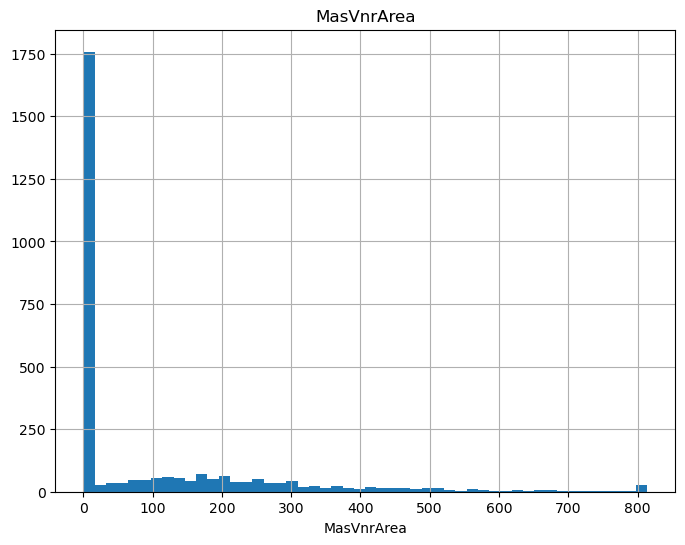

#####################################
count    2918.000000
mean      439.925805
std       444.134292
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%       202.600000
50%       368.500000
60%       515.200000
70%       656.000000
80%       812.000000
90%      1056.900000
95%      1274.000000
99%      1635.320000
max      2642.250000
Name: BsmtFinSF1, dtype: float64


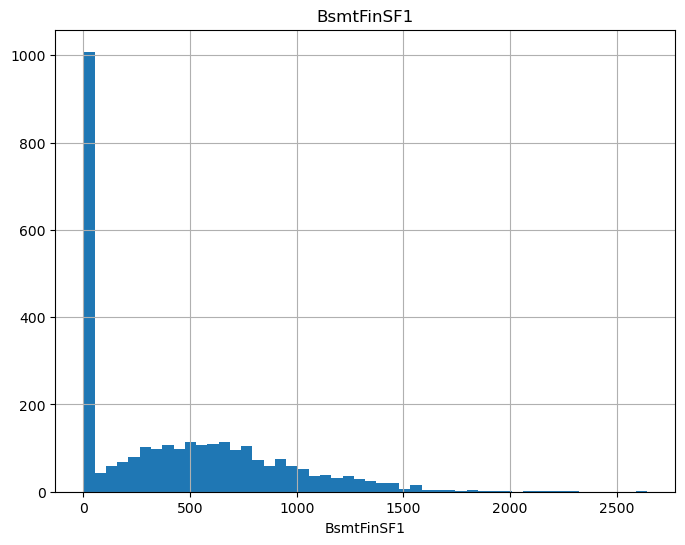

#####################################
count    2918.000000
mean       29.308773
std        85.778123
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       125.600000
95%       314.000000
99%       314.000000
max       314.000000
Name: BsmtFinSF2, dtype: float64


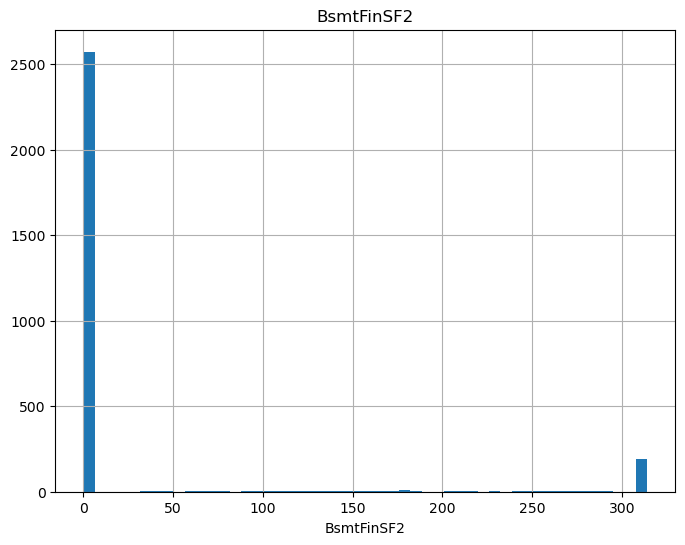

#####################################
count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
5%          0.000000
10%        56.000000
20%       174.000000
30%       270.000000
40%       365.800000
50%       467.000000
60%       595.000000
70%       732.000000
80%       892.600000
90%      1212.600000
95%      1474.900000
99%      1776.490000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


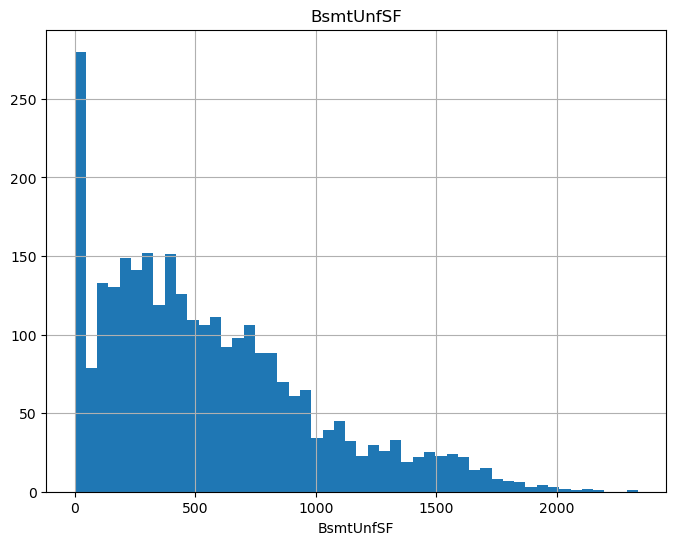

#####################################
count    2918.000000
mean     1050.038725
std       427.399357
min         0.000000
5%        455.250000
10%       600.000000
20%       741.000000
30%       836.000000
40%       911.000000
50%       989.500000
60%      1089.200000
70%      1216.000000
80%      1392.000000
90%      1614.000000
95%      1776.150000
99%      2198.300000
max      3135.000000
Name: TotalBsmtSF, dtype: float64


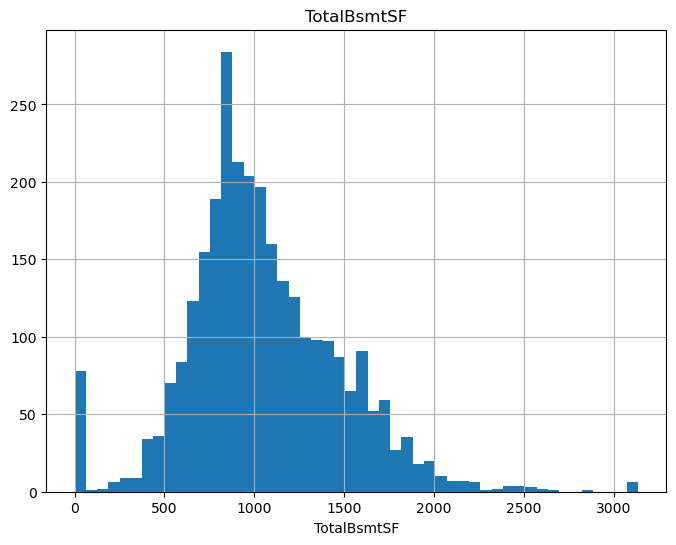

#####################################
count    2919.000000
mean     1157.998458
std       381.292918
min       334.000000
5%        665.900000
10%       744.800000
20%       847.000000
30%       914.000000
40%       996.200000
50%      1082.000000
60%      1180.000000
70%      1314.000000
80%      1483.400000
90%      1675.000000
95%      1830.100000
99%      2288.020000
max      3070.300000
Name: 1stFlrSF, dtype: float64


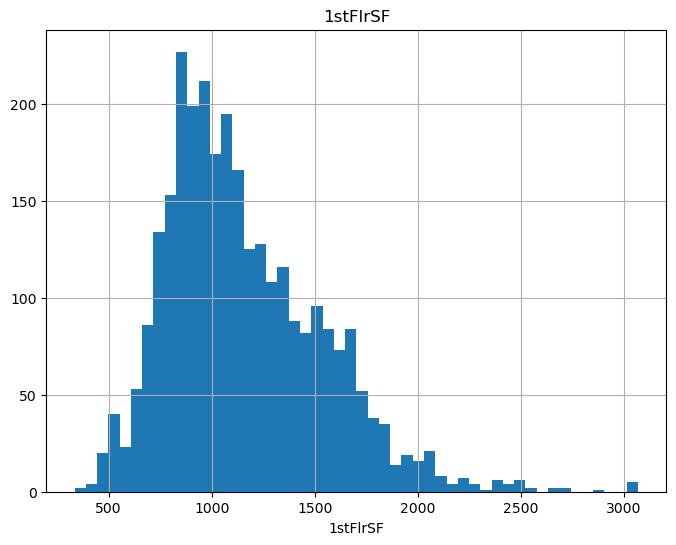

#####################################
count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       427.400000
70%       636.000000
80%       770.800000
90%       925.000000
95%      1131.200000
99%      1400.200000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


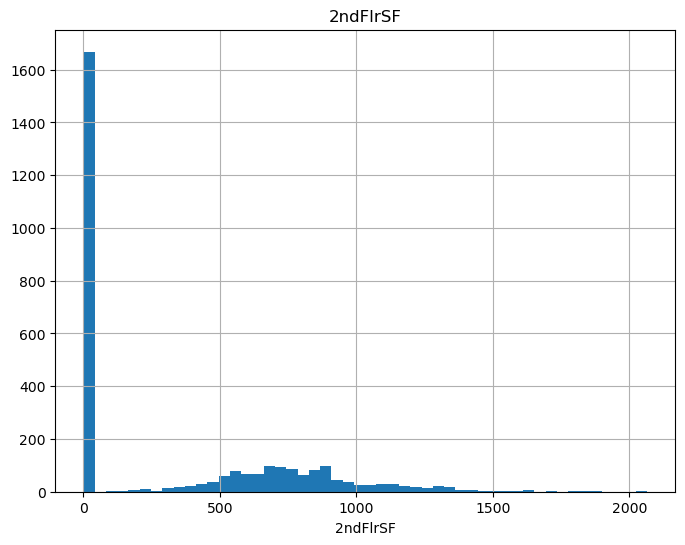

#####################################
count    2919.0
mean        0.0
std         0.0
min         0.0
5%          0.0
10%         0.0
20%         0.0
30%         0.0
40%         0.0
50%         0.0
60%         0.0
70%         0.0
80%         0.0
90%         0.0
95%         0.0
99%         0.0
max         0.0
Name: LowQualFinSF, dtype: float64


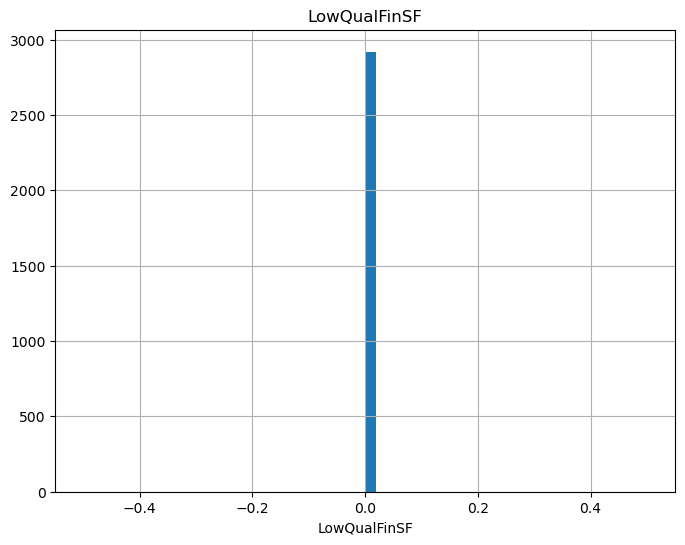

#####################################
count    2919.000000
mean     1499.314663
std       497.248442
min       334.000000
5%        861.000000
10%       923.800000
20%      1064.600000
30%      1200.000000
40%      1329.200000
50%      1444.000000
60%      1560.000000
70%      1680.000000
80%      1838.400000
90%      2153.200000
95%      2464.200000
99%      2935.720000
max      3997.300000
Name: GrLivArea, dtype: float64


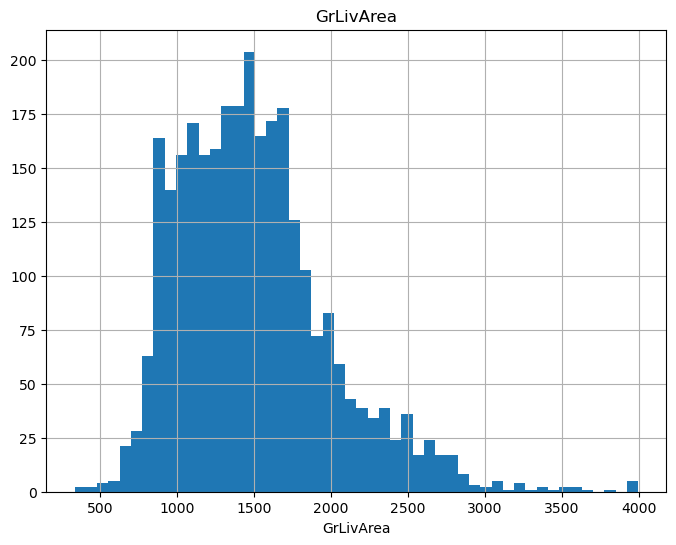

#####################################
count    2919.000000
mean        6.449983
std         1.562464
min         2.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         6.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        12.500000
Name: TotRmsAbvGrd, dtype: float64


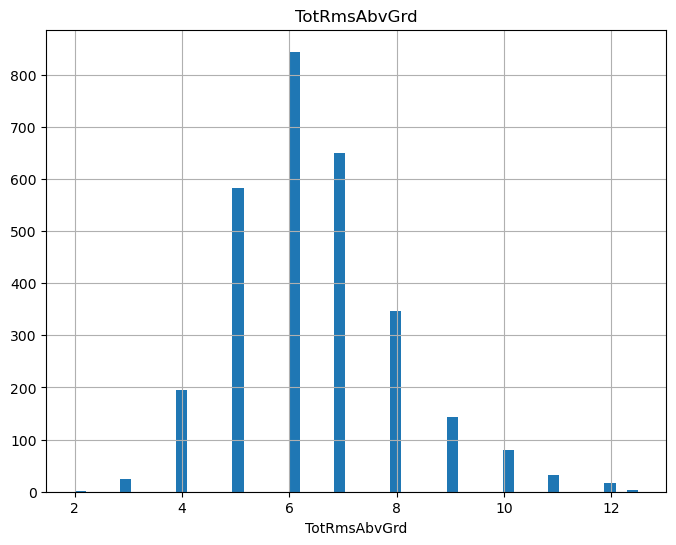

#####################################
count    2760.000000
mean     1978.075906
std        25.313091
min      1895.000000
5%       1928.000000
10%      1941.000000
20%      1957.000000
30%      1964.000000
40%      1972.000000
50%      1979.000000
60%      1993.000000
70%      1999.000000
80%      2004.000000
90%      2006.000000
95%      2007.000000
99%      2009.000000
max      2103.500000
Name: GarageYrBlt, dtype: float64


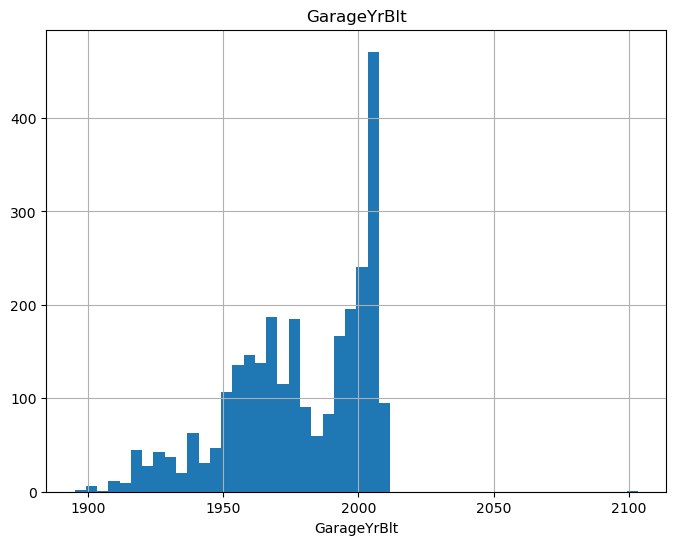

#####################################
count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
5%          0.000000
10%       240.000000
20%       296.000000
30%       379.000000
40%       440.000000
50%       480.000000
60%       513.000000
70%       560.900000
80%       621.000000
90%       758.000000
95%       856.150000
99%      1019.490000
max      1488.000000
Name: GarageArea, dtype: float64


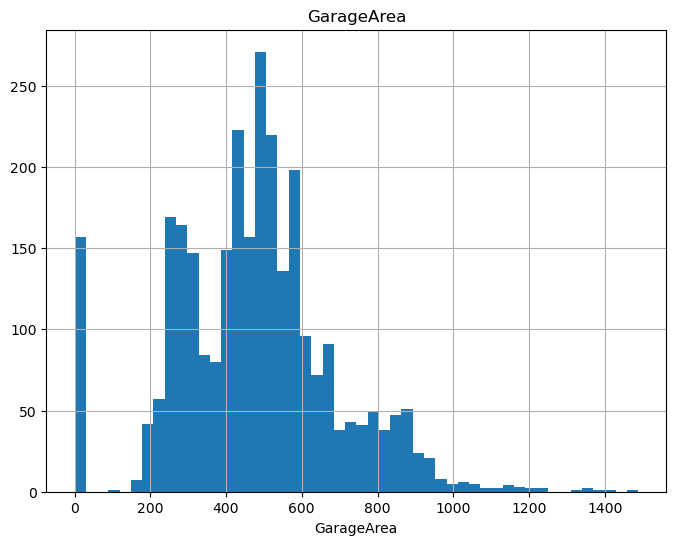

#####################################
count    2919.000000
mean       93.174546
std       123.169563
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       100.000000
70%       144.000000
80%       192.000000
90%       257.000000
95%       328.000000
99%       500.820000
max       642.500000
Name: WoodDeckSF, dtype: float64


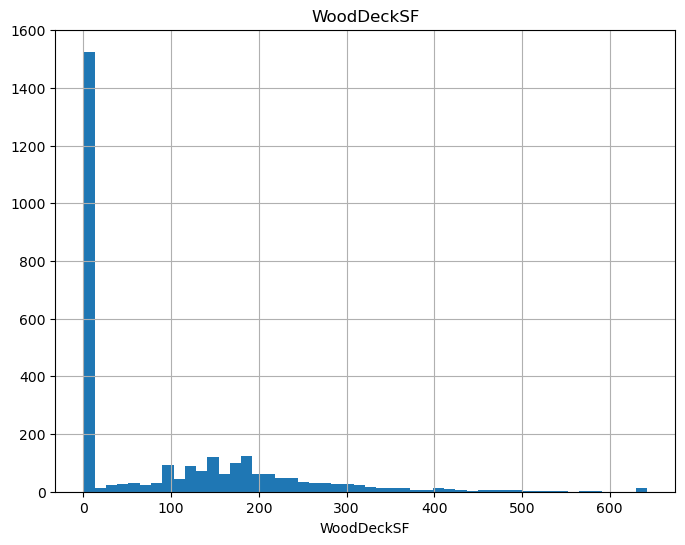

#####################################
count    2919.000000
mean       46.828708
std        63.694364
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%        26.000000
60%        40.000000
70%        58.000000
80%        85.000000
90%       131.200000
95%       183.100000
99%       284.460000
max       328.000000
Name: OpenPorchSF, dtype: float64


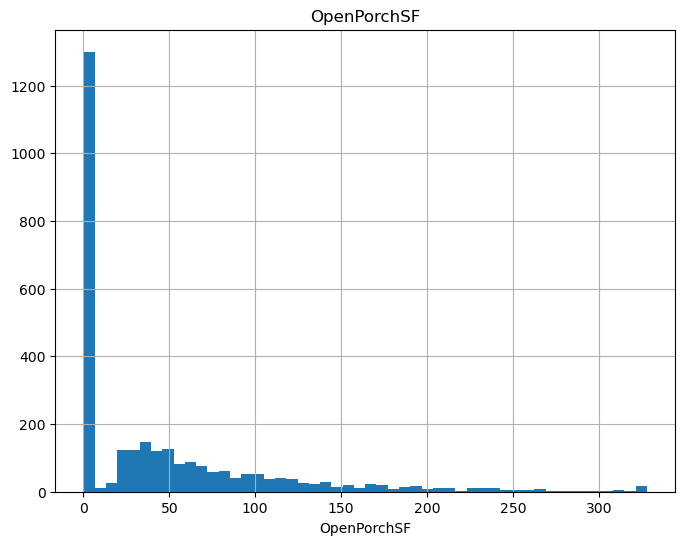

#####################################
count    2919.000000
mean       22.354231
std        58.955344
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       112.000000
95%       176.000000
99%       264.000000
max       280.000000
Name: EnclosedPorch, dtype: float64


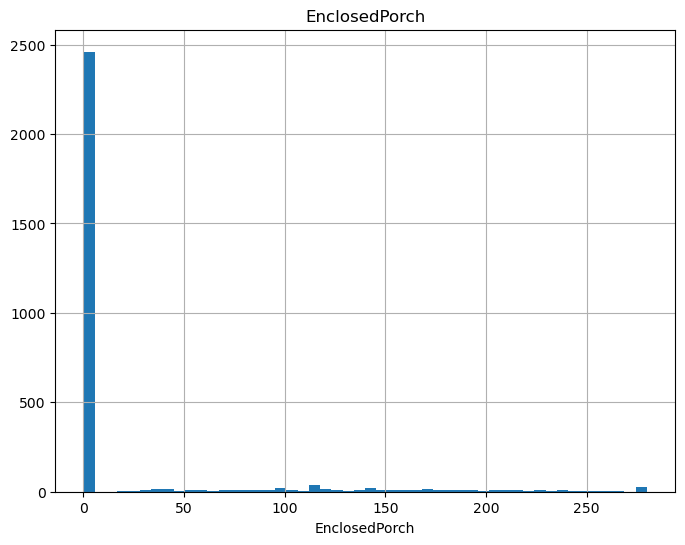

#####################################
count    2919.0
mean        0.0
std         0.0
min         0.0
5%          0.0
10%         0.0
20%         0.0
30%         0.0
40%         0.0
50%         0.0
60%         0.0
70%         0.0
80%         0.0
90%         0.0
95%         0.0
99%         0.0
max         0.0
Name: 3SsnPorch, dtype: float64


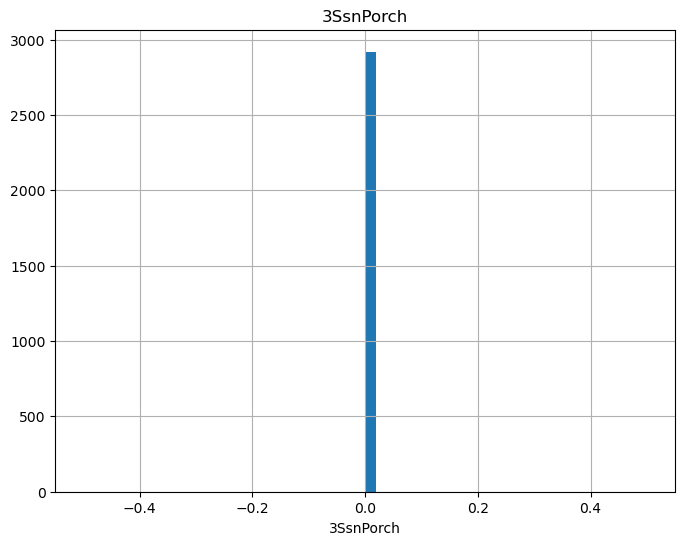

#####################################
count    2919.0
mean        0.0
std         0.0
min         0.0
5%          0.0
10%         0.0
20%         0.0
30%         0.0
40%         0.0
50%         0.0
60%         0.0
70%         0.0
80%         0.0
90%         0.0
95%         0.0
99%         0.0
max         0.0
Name: ScreenPorch, dtype: float64


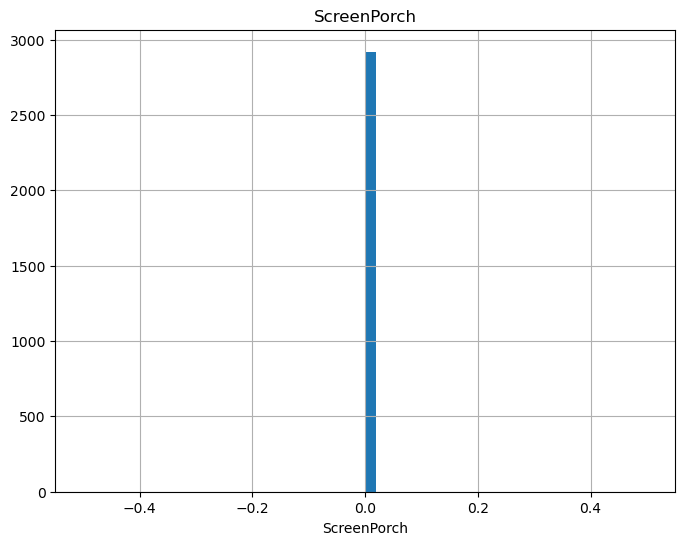

#####################################
count    2919.0
mean        0.0
std         0.0
min         0.0
5%          0.0
10%         0.0
20%         0.0
30%         0.0
40%         0.0
50%         0.0
60%         0.0
70%         0.0
80%         0.0
90%         0.0
95%         0.0
99%         0.0
max         0.0
Name: PoolArea, dtype: float64


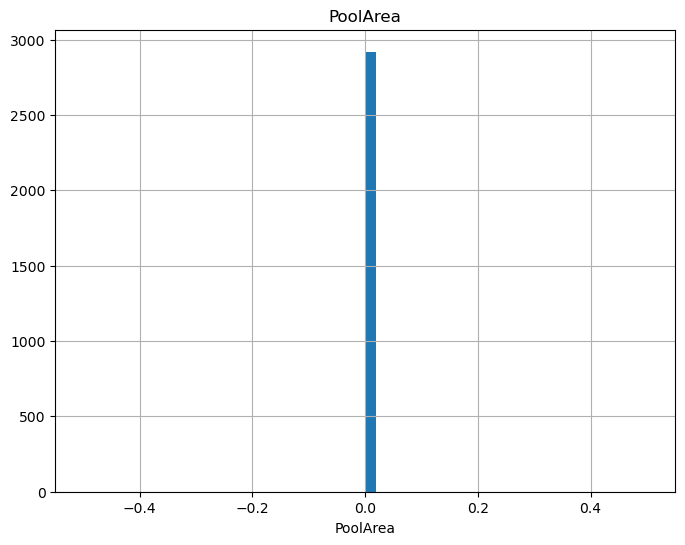

#####################################
count    2919.0
mean        0.0
std         0.0
min         0.0
5%          0.0
10%         0.0
20%         0.0
30%         0.0
40%         0.0
50%         0.0
60%         0.0
70%         0.0
80%         0.0
90%         0.0
95%         0.0
99%         0.0
max         0.0
Name: MiscVal, dtype: float64


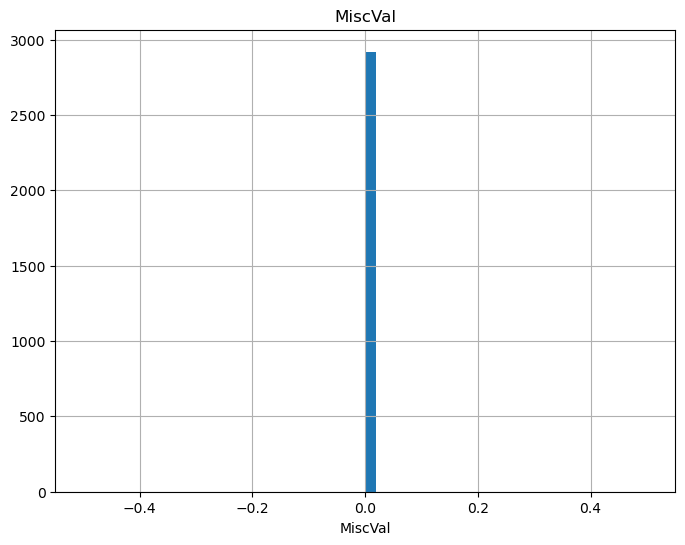

#####################################
count    2919.000000
mean        6.213087
std         2.714762
min         1.000000
5%          2.000000
10%         3.000000
20%         4.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%        10.000000
95%        11.000000
99%        12.000000
max        12.000000
Name: MoSold, dtype: float64


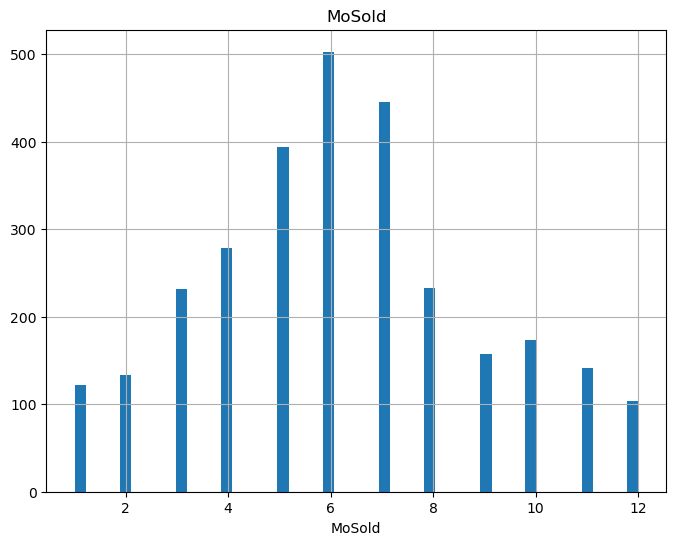

#####################################
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
10%      106475.000000
20%      124000.000000
30%      135500.000000
40%      147000.000000
50%      163000.000000
60%      179280.000000
70%      198620.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64


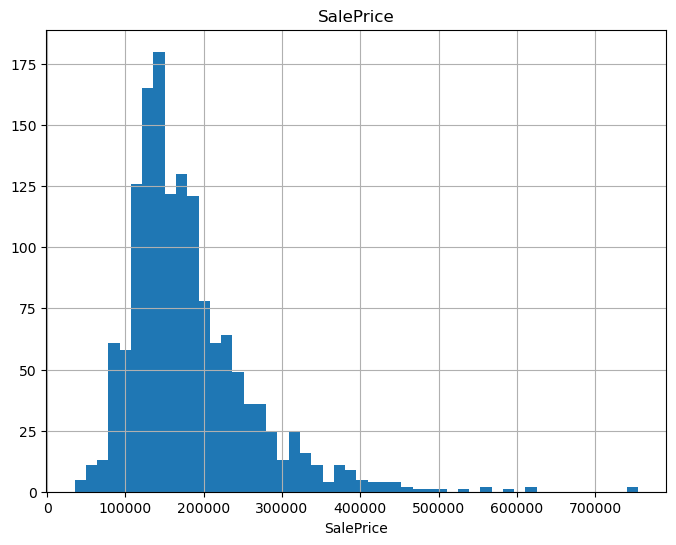

#####################################


In [10]:
"""
    Quantile degerlerinin anlami su şekildedir:

    Minimum (0.0 Quantile): Veri setinin en kucuk degeri.
    1. Ceyrek (25. persentil veya 0.25 Quantile): Veri setinin ilk ceyregi.
    Medyan (50. persentil veya 0.50 Quantile): Veri setinin orta degeri.
    3. Çeyrek (75. persentil veya 0.75 Quantile): Veri setinin ucuncu çeyregi.
    Maksimum (1.0 Quantile): Veri setinin en buyuk degeri.
    
    veri setinin dagilimini daha iyi anlamak ve olasi aykiri degerleri tanimlamak için kullanilir.
"""
def num_summary(dataframe, numerical_col, plot=False, output_file=None):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary_stats = dataframe[numerical_col].describe(quantiles).T
    print(summary_stats)

    if plot:
        # Plot'u ekrana göster
        plt.figure(figsize=(8, 6))
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

        # Plot'u dosyaya kaydet
        if output_file:
            plt.figure(figsize=(8, 6))
            dataframe[numerical_col].hist(bins=50)
            plt.xlabel(numerical_col)
            plt.title(numerical_col)
            plt.savefig(output_file, format='pdf', bbox_inches='tight')
            plt.close()

    print("#####################################")


output_file_path = 'numerical_summary_histograms.pdf'

with PdfPages(output_file_path) as pdf:
    for col in num_cols:
        num_summary(df, col, plot=True, output_file=pdf)


In [11]:
#Hedef degisken analizi
#Kategorilere gore hedef degiskenin ortalamasini buluyor.Kategorilerin hedef degiskene etkileri
def analys_target_with_cat(dataframe, target, cat_col,output_file=None):
    result_df = pd.DataFrame({"TARGET_MEAN": dataframe.groupby(cat_col)[target].mean()})
    print(result_df)
    
for col in cat_cols:
    analys_target_with_cat(df,"SalePrice",col)

            TARGET_MEAN
MSZoning               
C (all)    74528.000000
FV        214014.061538
RH        131558.375000
RL        191004.994787
RM        126316.830275
          TARGET_MEAN
Street               
Grvl    130190.500000
Pave    181130.538514
         TARGET_MEAN
Alley               
Grvl   122219.080000
Pave   168000.585366
            TARGET_MEAN
LotShape               
IR1       206101.665289
IR2       239833.365854
IR3       216036.500000
Reg       164754.818378
               TARGET_MEAN
LandContour               
Bnk          143104.079365
HLS          231533.940000
Low          203661.111111
Lvl          180183.746758
            TARGET_MEAN
Utilities              
AllPub     180950.95682
NoSeWa     137500.00000
             TARGET_MEAN
LotConfig               
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside     176938.047529
             TARGET_MEAN
LandSlope               
Gtl        179956.799566
Mod     

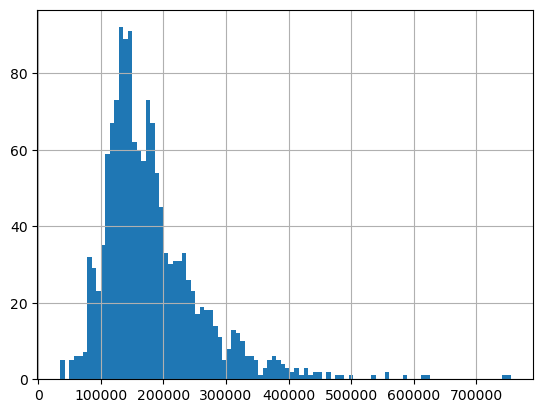

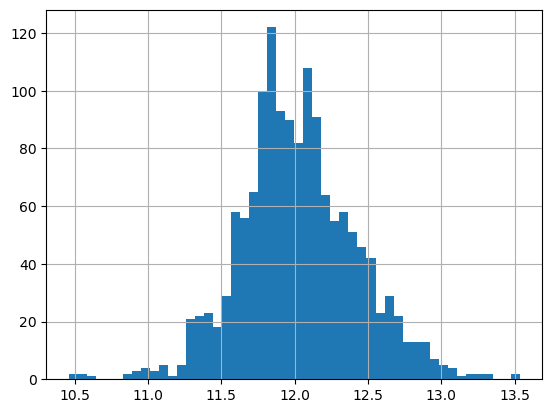

In [12]:
"""
    x ekseni, "SalePrice" degiskeninin deger araliklari
    y ekseni her bir deger araligindaki frekans
    
    Logaritma, ozellikle veri setlerinde buyuk degerlerin bulundugu durumlar icin kullanilir. 
    Ornegin, gelir veya ev fiyatlari gibi buyuk degerlere sahip bir degiskenin logaritmik donusumu, 
    bu degerler arasindaki farklari daha dengeli bir sekilde gosterir.
"""
# Bagimli degiskenin incelenmesi
df["SalePrice"].hist(bins=100)
plt.show()

# Bagimli degiskenin logaritmasinin incelenmesi
np.log1p(df['SalePrice']).hist(bins=50)
plt.show()

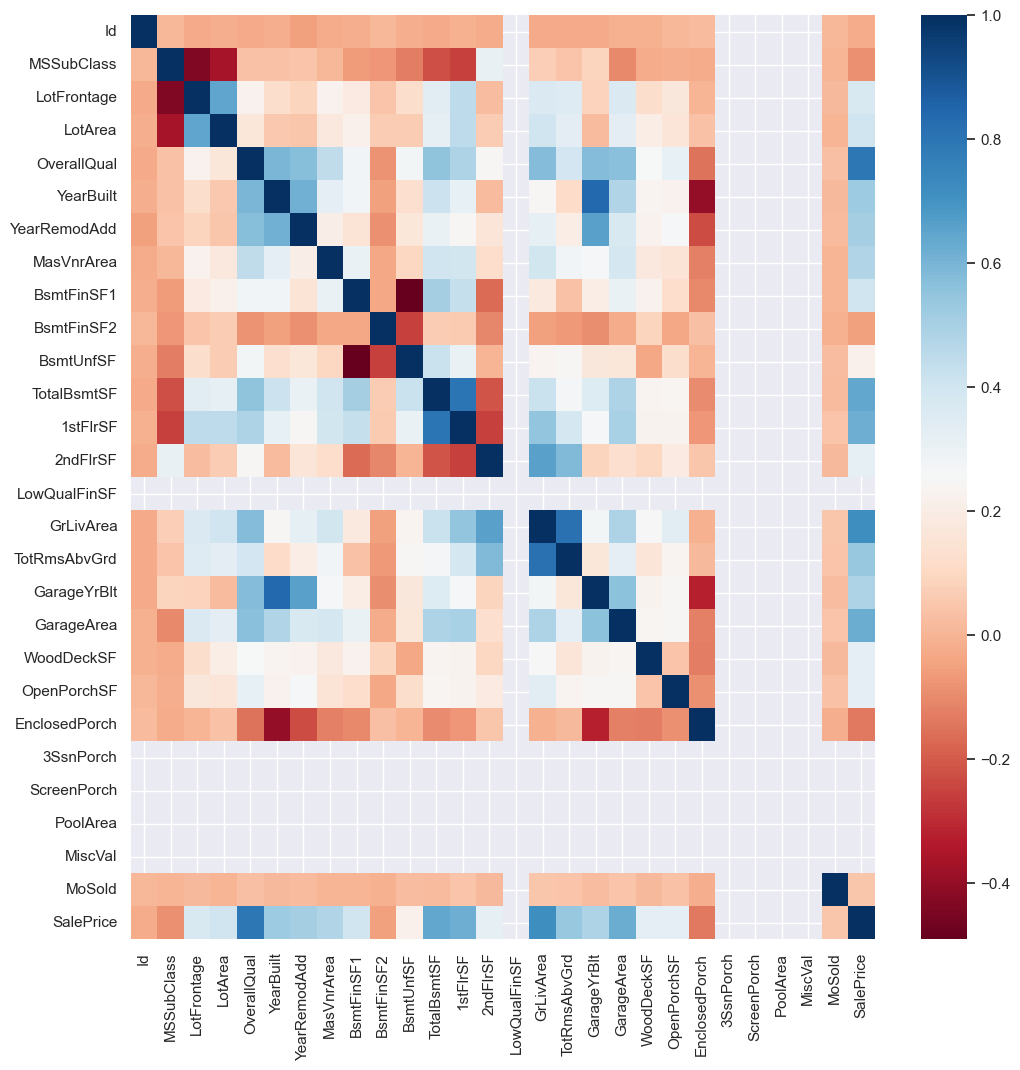

In [13]:
#Korelasyon Analizi
"""
    iki degisken arasindaki iliskinin gucunu ve yonsel niteligini belirlemek icin kullanilan istatistiksel bir analiz yontemi
"""
correlation = df[num_cols].corr()
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(correlation, cmap="RdBu")
plt.savefig("correlation_matrix.png")

plt.show()

In [21]:
def high_correlated_cols(dataframe, corr_threshold=0.70, plot=False,output_file=None):
    corr = dataframe.corr(numeric_only=True)
    cor_matrix = corr.abs() # korelasyonun buyuklugu (pozitif ya da negatif olup olmadigi onemli degil) onemlidir.
    
    #korelasyonda simetrik degerler oldugundan üst ücgeni alir.
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
    
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_threshold)]
    print(drop_list)
    
    with PdfPages(output_file) as pdf:
        for X in drop_list:
            for Y in drop_list:
                if X != Y and X < Y:
                    sns.scatterplot(x=X,y=Y, data=dataframe)
                    plt.title(f"{X} vs {Y}")
                    pdf.savefig()  # Her scatter plot'u PDF'ye ekler
                    plt.show()


high_correlated_cols(df, plot=False,output_file="correlation relationship between variables.pdf")

C:\Users\umutcan\AppData\Local\Temp\ipykernel_16100\2255451178.py:6: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [16]:
""" Bazi degiskenleri birlestirelim ve veri setimizi sade hale getirmeye calisalim
    Tabi bunu yaparken anlamli kategorileri birlestirmeliyiz 
"""
# birinci katin genisligi ile zemin disindaki yasam alaninin genisligi arasindaki bir iliskiyi yansitir
df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"] 

# # garajın genisligi ile zemin disindaki yasam alaninin genisligi arasindaki bir iliskiyi yansitir
df["NEW_Garage*GrLiv"] = (df["GarageArea"] * df["GrLivArea"])

# kalite toplamini bir arada toplayip tek bir değişkende tanimlandi.
df["ExterQual"] = df["ExterQual"].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
df["ExterCond"] = df["ExterCond"].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
df["BsmtCond"] = df["BsmtCond"].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
df["BsmtFinType1"] = df["BsmtFinType1"].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2,'Unf':1, np.nan: 0})
df["BsmtFinType2"] = df["BsmtFinType2"].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2,'Unf':1, np.nan: 0})
df["HeatingQC"] = df["HeatingQC"].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
df["FireplaceQu"] = df["FireplaceQu"].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
df["KitchenQual"] = df["KitchenQual"].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
df["GarageQual"] = df["GarageQual"].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
df["GarageCond"] = df["GarageCond"].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
df["Fence"] = df["Fence"].map({'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0})


df["TotalQual"] = df[["OverallQual", "OverallCond","ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",  "BsmtFinType2", "HeatingQC", "KitchenQual",
                     "FireplaceQu", "GarageQual", "GarageCond", "Fence"]].sum(axis = 1) 

# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"] 

# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2 

# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF 

# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF # 156

df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF # 35


# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea # 64

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea # 57

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea # 69

# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea # 36

# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF) # 73


df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"] # 61


df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt # 31

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt # 73

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd # 40

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt # 17

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd) # 30

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt # 48



drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

# drop_list'teki değişkenlerin düşürülmesi
df.drop(drop_list, axis=1, inplace=True)



In [17]:
# Label Encoding & One-Hot Encoding
cat_cols, cat_but_car, num_cols = catch_cat_and_num_categ(df)

# ikili (binary) kategorik sütunları (değişkenleri) sayısal forma dönüştürmek için
binary_cols = [col for col in df.columns if df[col].dtype == "O" and len(df[col].unique()) == 2 ]

def label_encoding(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    
    return dataframe

for col in binary_cols:
    label_encoding(df,col)


Observations: 2919
Variables: 92
cat_cols: 49
num_cols: 43
cat_but_car: 0
num_but_cat: 26


In [18]:
"""
    One-Hot Encoding, her bir kategori degeri icin yeni bir sutun olusturur ve her bir gozlemin 
    bu kategoriyi icerip icermedigini gostermek icin 1 ve 0'lari kullanir.

    drop_first: Bu parametre, One-Hot Encoding s,rasinda bir sutunun dusurulup dusurulmeyecegini belirler. 
                Eger True olarak ayarlanirsa, her kategori icin olusturulan sutunlardan biri dusurulur.
    
    pd.get_dummies: Bu fonksiyon, One-Hot Encoding islemi uygular. dataframe icindeki categorical_cols 
                    sutunlarna uygulanir ve her bir kategorik degeri yeni sutunlara donusturur.
                    
    Bu parametre, coklu baglanti (multicollinearity) sorunlarini onlemeye yardimci olabilir. Coklu baglanti, 
    bir veya daha fazla bagimsiz degiskenin diğer bagimsiz degiskenlerle yuksek bir korelasyona sahip olmasi durumunu ifade eder. 
"""
def one_hot_encoding(dataframe, cat_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoding(df, cat_cols, drop_first=True)

In [20]:
#  Train ve Test verisini ayırınız. (SalePrice değişkeni boş olan değerler test verisidir.)
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

y = train_df['SalePrice']
X = train_df.drop(['SalePrice'], axis=1)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]




0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\umutcan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\umutcan\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\umutcan\anaconda3\Lib\site-packages\sklearn\linear_model\_base.py", line 678, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\umutcan\anaconda3\Lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\umutcan\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\umutcan\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 959, in check_array
    _assert_all_finite(
  File "C:\Users\umutcan\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\umutcan\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
